# Поиск оптимальной стратегии методом Монте-Карло

Реализуем поиск оптимальной стратегии по методу Монте-Карло с помощью ОИС с итерацией по $\varepsilon$-мягким стратегиям с GLIE, то есть с постепенным убыванием $\varepsilon$. Этот метод базируется на вычислении оценки Q-функции. Ранее, мы использовали "табличного" агента для оценки стратегии по методу Монте-Карло. Этот агент приближал V-функцию. Изменим код этого "табличного" агента, чтобы он теперь приближал Q-функцию. Добавим также метод `play(env,n_episodes)` для симуляции работы обученного агента.

Программно Q-функцию также удобно реализовать как словарь `defaultdict`. Словарь заполняется по ходу взаимодействия со средой. Ключами будут состояния `s`, а значениями являются вектора, содержащие числа `Q[s][a]` для всех возможных действий. Число, хранящееся в `Q[s][a]`, и является оценкой ценности ценности действия `a` в состоянии `s`.

Кроме того, стратегии теперь формируются как $\varepsilon$-жадные стратегии относительно текущей оценки Q-функции, поэтому изменим и метод `get_action()` соответствующим образом. Поле `policy`, отвечавшее ранее за хранение стратении, теперь не требуется.

In [3]:
import numpy as np
from collections import defaultdict

class TableAgent:
    def __init__(self, env, eps = 0.1, alpha = None):
        self.nA = env.action_space.n # число действий
        self.N = defaultdict(lambda: np.zeros(self.nA))   # словарь для хранения числа посещений пар состояние-действие
        self.Q = defaultdict(lambda: np.zeros(self.nA))   # словарь для хранения оценок ценностей пар состояние-действие
        self.eps = eps               
        self.alpha = alpha           # параметр шага обучения
            
    def reset(self):
        self.N = defaultdict(lambda: np.zeros(self.nA))
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
    # выбор eps-жадного действия        
    def get_action(self, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.nA)

        return self.best_action(state)

    def best_action(self, state):
        return np.argmax(self.Q[state])
    
    def update(self, state, act, goal):
        # обновление оценки по методу выборочного среднего или с постоянным шагом обновления
        if self.alpha is None:
            self.N[state][act] += 1
            self.Q[state][act] += (goal - self.Q[state][act])/self.N[state][act]
        else:
            self.Q[state][act] += self.alpha*(goal - self.Q[state][act])
    
    def play(self, env, n_episodes):
        for episode in range(n_episodes):
            state, _ = env.reset()
            while True:
                # выбираем лучшие действия
                action = self.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

Далее, скопируем код для генерации эпизода. Отметим, что теперь траектории генерируются по $\varepsilon$-жадной стратегии относительно текущей Q-функции. 

Также, сформируем управляющий алгоритм `MC_Control()` для поиска оптимальной стратегии в соответствии с приведённым в лекциях псевдокодом. Добавим туда возможности управлять изменением убывания $\varepsilon$. 

Также напишем метод, извлекающий жадную стратегию относительно текущих оценок Q-функции в виде словаря.

In [5]:
from tqdm import tqdm

def generate_episode(env, agent):    
    episode = [] #список для хранения траектории
    state, _ = env.reset()    
    while True:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)      
        episode.append((state, action, reward))
        state = next_state
        if terminated or truncated:
                break
    return episode

def MC_Control(env, agent, n_episodes, gamma=1.0, 
               eps_start=1.0, eps_decay=.99999, eps_min=0.05, first_visit=False):
    agent.eps = eps_start
    # цикл числу эпизодов
    for _ in tqdm(range(n_episodes)):
        # генерация траектории по eps-жадной стратегии относительно Q
        episode = generate_episode(env, agent)       
        # если МК первого посещения, то выделим из эпизода все пары состояние-действие
        if first_visit:
            episode_states, episode_acts, _ = zip(*episode)
            s_a_pairs = list(zip(episode_states,episode_acts))

        # подсчёт доходов и обновление оценок
        G = 0
        ep_length = len(episode)
        for t in range(ep_length-1, -1, -1):
            s, a, r = episode[t]
            G = gamma*G + r
            if first_visit:
                if (s, a) not in s_a_pairs[:t]:
                    agent.update(s,a,G)
            else:                    
                agent.update(s,a,G)
        # уменьшить eps
        agent.eps = max(agent.eps*eps_decay, eps_min)
        
def get_greedy_policy(agent):
    # Получение жадной стратегии относительно текущей Q-функции
    greedy_policy = dict((state, np.argmax(Qvalues)) for state, Qvalues in agent.Q.items())
    return greedy_policy

Также удобно ввести функции, позволяющие сохранить обученную Q-функцию и загрузить Q-функцию в агента из файла. Для этого используем библиотеку `pickle`.

In [53]:
import pickle

def save_Q(agent, name):
    # При сохранении напрямую pickle.dump(agent.Q,f) возникает ошибка Can't pickle local object,
    #  поскольку сохранятеся не словарь dict, а defaultdict. Поэтому переписываем все значения в обычный словарь
    f = open('savedModels/'+name+".pkl",'wb')
    dict_tmp = {}
    for key in agent.Q.keys():
        dict_tmp[key] = agent.Q[key]    
    pickle.dump(dict_tmp,f)
    f.close()
    return 'savedModels/'+name+".pkl"
    
def load_Q(agent, name):
    f = open(name,'rb')
    dict_tmp = pickle.load(f)
    f.close()
    agent.reset()
    for key in dict_tmp.keys():
        agent.Q[key] =  dict_tmp[key]

### Пример 1

Рассмотрим задачу о сеточном мире 4 на 4 и найдём оптимальную стратегию методом Монте-Карло.
Проведём, например, 1000 симуляций, выведем значения функции ценности состояний.

In [7]:
from custom.env.gridworld import GridWorld4by4

env = GridWorld4by4()
agent = TableAgent(env)

In [17]:
agent = TableAgent(env)
MC_Control(env, agent, 1000, eps_decay=.97)

V_opt = dict((state,np.max(Qvalue)) for state, Qvalue in agent.Q.items())
V_list = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        pos = 4*i+j
        V_list[i,j] = V_opt[pos]
    
V_list

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 14210.42it/s]


array([[ 0.        , -1.        , -2.43661972, -4.22222222],
       [-1.        , -2.1835443 , -3.42696629, -2.24137931],
       [-2.25157233, -3.24375   , -2.16949153, -1.        ],
       [-3.42682927, -4.23595506, -1.        ,  0.        ]])

Выведем также одну из оптимальных стратегий.

In [19]:
policy = get_greedy_policy(agent)
action_labels = {0:"LEFT", 1:"DOWN", 2: "RIGHT", 3:"UP"}
optimal_actions=[0]*16
for i in range(4):
    for j in range(4):
        optimal_actions[4*i+j] = action_labels[policy[4*i+j]]

optimal_actions[0] = "*" 
optimal_actions[15] = "*" 

print("Стратегия:\n",np.array(optimal_actions).reshape((4,4)))

Стратегия:
 [['*' 'LEFT' 'LEFT' 'DOWN']
 ['UP' 'LEFT' 'LEFT' 'DOWN']
 ['UP' 'RIGHT' 'RIGHT' 'DOWN']
 ['UP' 'UP' 'RIGHT' '*']]


Симуляция на 1000 эпизодов показывает достаточно хорошие результаты с точки зрения поиска оптимальной стратегии, хотя не все значения Q-функции за 1000 эпизодов сошлись к оптимальным значениям. И не при каждом запуске за 1000 эпизодов стратегия действительно сходится к оптимальной.

Большее число эпизодов позволяет гарантированно добраться до оптимальной стратегии.

Например, запустим обучения с фиксированным шагом обучения, обучение на 20000 эпизодах находит оптимальную стратегтю, хотя есть некоторая погрешность в значениях Q-функции за 20000 эпизодов по сравнению с оптимальными значениями.

In [21]:
gamma = 1.0
env = GridWorld4by4()
agent = TableAgent(env, alpha = 0.2)


MC_Control(env, agent, 20000, eps_decay=.99)

100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:01<00:00, 16947.08it/s]


In [23]:
V_opt = dict((state,np.max(Qvalue)) for state, Qvalue in agent.Q.items())
V_list = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        pos = 4*i+j
        V_list[i,j] = V_opt[pos]
    
V_list

array([[ 0.        , -1.        , -2.00001809, -3.17956916],
       [-1.        , -2.05833463, -3.00242848, -2.12079596],
       [-2.19077469, -3.44417181, -2.00001929, -1.        ],
       [-3.22482076, -2.20775148, -1.        ,  0.        ]])

In [25]:
policy = get_greedy_policy(agent)
action_labels = {0:"LEFT", 1:"DOWN", 2: "RIGHT", 3:"UP"}
optimal_actions=[0]*16
for i in range(4):
    for j in range(4):
        optimal_actions[4*i+j] = action_labels[policy[4*i+j]]

optimal_actions[0] = "*" 
optimal_actions[15] = "*" 

print("Стратегия:\n",np.array(optimal_actions).reshape((4,4)))

Стратегия:
 [['*' 'LEFT' 'LEFT' 'DOWN']
 ['UP' 'UP' 'DOWN' 'DOWN']
 ['UP' 'UP' 'RIGHT' 'DOWN']
 ['UP' 'RIGHT' 'RIGHT' '*']]


### Пример 2

Рассмотрим работу методов Монте-Карло для поиска оптимальной стратегии на примере среды **Blackjack**. Запустим обучение на 500000 эпизодах.

In [39]:
import gymnasium as gym

env = gym.make('Blackjack-v1')

agent = TableAgent(env)
MC_Control(env, agent, 50000, gamma = 1.0, eps_start=1.0, eps_decay=.99995, eps_min=0.001)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:07<00:00, 6528.00it/s]


Построим график найденной V-функции. Будем считать, что найденная Q-функция оптимальна, тогда V-функция получается из Q-функции следующим образом:

$$
V(s) = \max_a Q(s,a)
$$

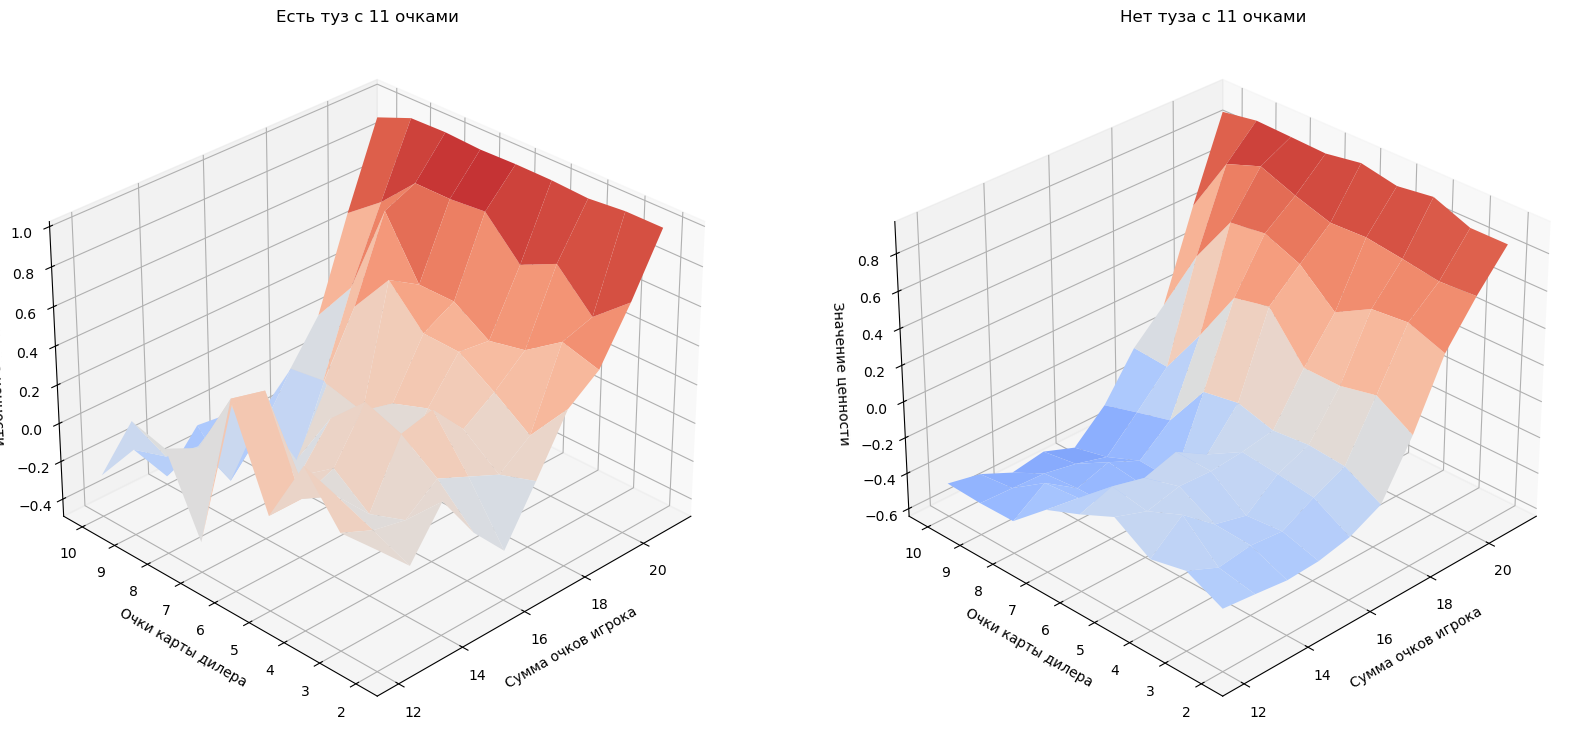

In [41]:
V_opt = defaultdict(lambda: 0)
for state, Qvalue in agent.Q.items():
    V_opt[state]  = np.max(Qvalue)

import matplotlib.pyplot as plt

# функция для построения графика
def get_figure(V, usable_ace, ax):
    # создание списка аргументов
    x_range = np.arange(12, 22)
    y_range = np.arange(2, 11)
    X, Y = np.meshgrid(x_range, y_range)
    all_x_y = zip(np.ravel(X), np.ravel(Y))
    # получаем значения по оси Oz 
    Z = np.array([V[x, y, usable_ace] for x,y in all_x_y])
    Z = Z.reshape(X.shape)
    # строим 3D график
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Сумма очков игрока')
    ax.set_ylabel('Очки карты дилера')
    ax.set_zlabel('Значение ценности')
    #установка угла зрения на график
    ax.view_init(30, -135)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Есть туз с 11 очками')
get_figure(V_opt, True, ax)
ax = fig.add_subplot(122, projection='3d')
ax.set_title('Нет туза с 11 очками')
get_figure(V_opt, False, ax)

Проведём также симуляцию на 50000 эпизодах, чтобы выявить среднее число выигранных игр и средний доход.

In [43]:
import gymnasium as gym

n_episodes = 10000
env = gym.make('Blackjack-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent.play(env, n_episodes)

In [45]:
print('Процент победных эпизодов: ', np.round(env.return_queue.count(1.0)/n_episodes*100,2))
print('Процент проигранных эпизодов: ', np.round(env.return_queue.count(-1.0)/n_episodes*100,2))
print('Процент эпизодов в ничью: ', np.round(env.return_queue.count(0.0)/n_episodes*100,2))
print('Средний доход:', np.mean(env.return_queue))

Процент победных эпизодов:  42.6
Процент проигранных эпизодов:  49.1
Процент эпизодов в ничью:  8.3
Средний доход: -0.065


Как видно, средний выигрыш при найденной стратегии не превосходит 0. 

Визуализируем также графически стратегию. Для этого используем следующий код.

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(12, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[11.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Очки агента')
        ax.set_ylabel('Карта дилера')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Есть туз с 11 очками')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('Нет туза с 11 очками')
    get_figure(False, ax)
    plt.show()

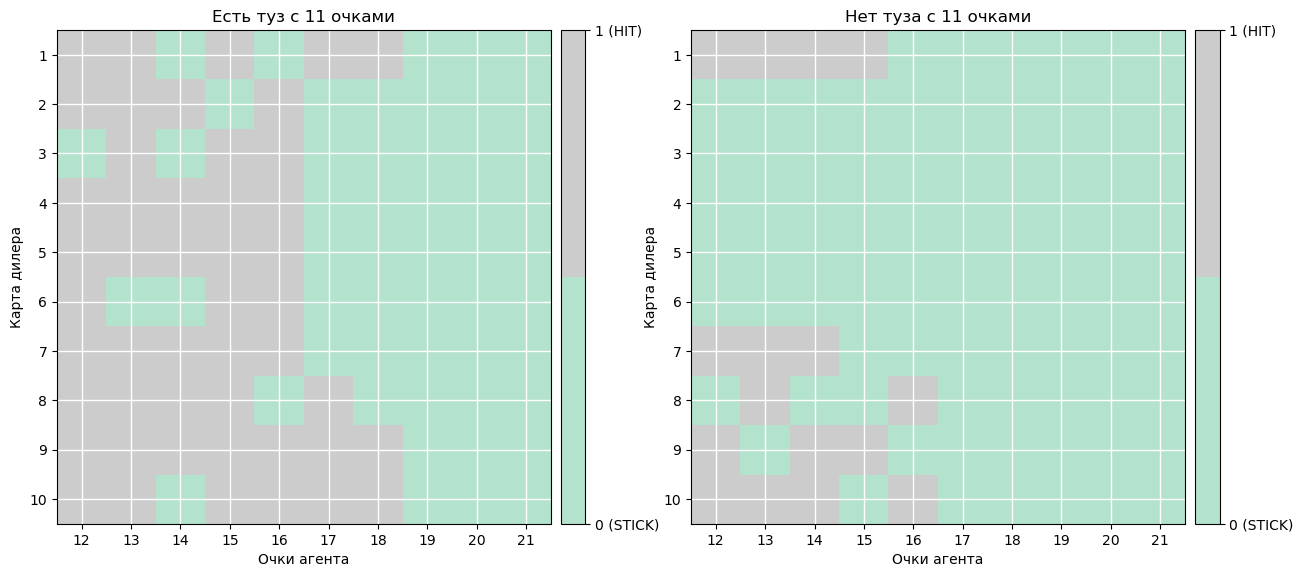

In [49]:
policy = get_greedy_policy(agent)
plot_policy(policy)

Можно увеличить число эпизодов обучения, чтобы получить стратегию, известную как оптимальная.

In [19]:
import gymnasium as gym

env = gym.make('Blackjack-v1')

agent_best = TableAgent(env, alpha = 0.001)

MC_Control(env, agent_best, 5000000, gamma = 1.0, eps_start=1.0, eps_decay=.9999, eps_min=0.0005)

100%|██████████████████████████████████████████████████████████████████████| 5000000/5000000 [12:17<00:00, 6783.50it/s]


Сохраним эту найденную Q-функцию.

In [20]:
save_Q(agent_best, 'MC_Blackjack_5M')

'savedModels/MC_Blackjack_5M.pkl'

Эту стратегию можно подгрузить из файла.

In [55]:
agent_best = TableAgent(env)
load_Q(agent_best, 'savedModels/MC_Blackjack_5M.pkl')

Визуализируем полученную V-функцию и соответствующую стратегию.

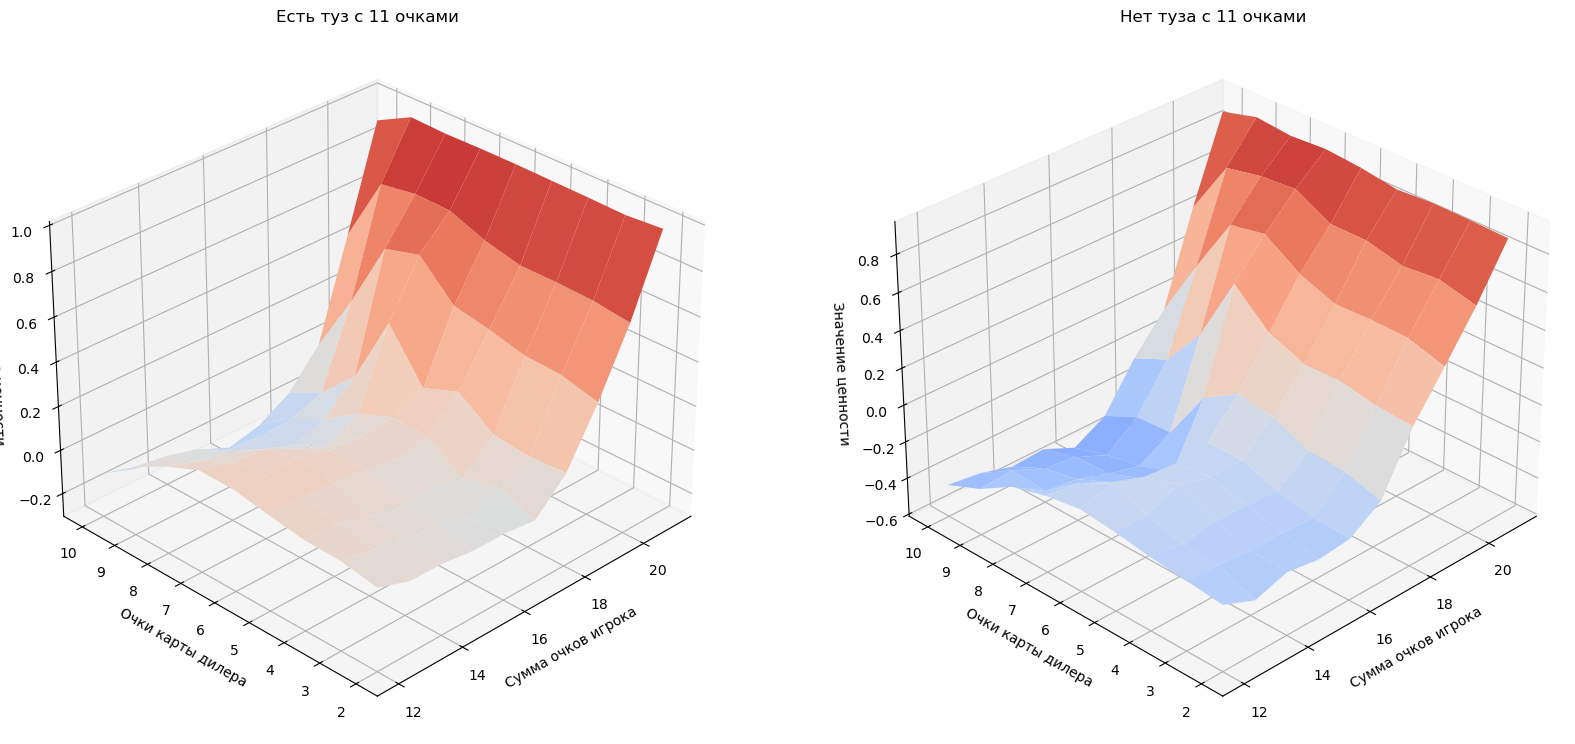

In [57]:
import matplotlib.pyplot as plt
# получим V-функцию
V_opt = dict((k,np.max(v)) for k, v in agent_best.Q.items())

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Есть туз с 11 очками')
get_figure(V_opt, True, ax)
ax = fig.add_subplot(122, projection='3d')
ax.set_title('Нет туза с 11 очками')
get_figure(V_opt, False, ax)

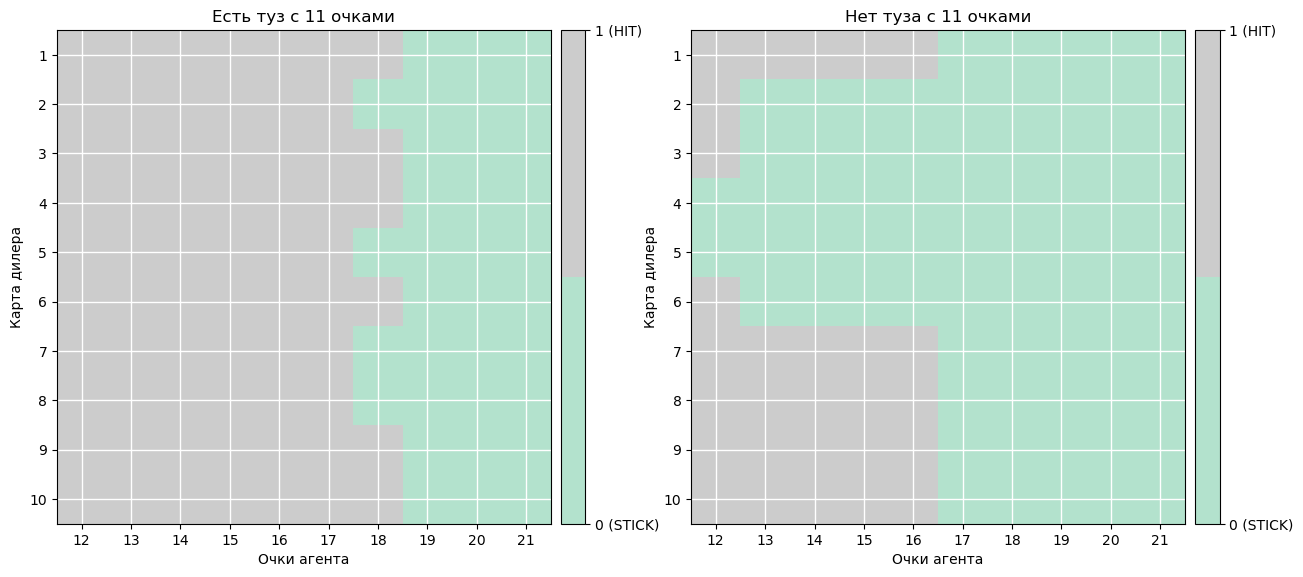

In [59]:
policy = get_greedy_policy(agent_best)
plot_policy(policy)

In [71]:
n_episodes = 10000
env = gym.make('Blackjack-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent.play(env, n_episodes)

print('Процент победных эпизодов: ', np.round(env.return_queue.count(1.0)/n_episodes*100,2))
print('Процент проигранных эпизодов: ', np.round(env.return_queue.count(-1.0)/n_episodes*100,2))
print('Процент эпизодов в ничью: ', np.round(env.return_queue.count(0.0)/n_episodes*100,2))
print('Средний доход:', np.mean(env.return_queue))

Процент победных эпизодов:  42.58
Процент проигранных эпизодов:  48.99
Процент эпизодов в ничью:  8.43
Средний доход: -0.0641


### Задача: реализовать метод Монте-Карло для поиска оптимальной стратегии с исследовательскими стартами.

Сравнить работу метода Монте-Карло при

1. обучении по $\varepsilon$-жадной стратегии
2. обучении по жадной стратегии, но с исследовательскими стартами

на примере среды "FrozenLake-v1" в `gymnasium` с выбранными ниже параметрами.

Чтобы поместить агента в выбранное состояние среды, надо использовать код:

    _, _ = env.reset()    
    env.unwrapped.s = any_possible_state

In [7]:
def generate_episode_ES(env, agent):    

def MC_Control_ES(env, agent, n_episodes, gamma=1.0, eps_start=1.0, eps_decay=.9, eps_min=0.01, first_visit=False):


Обучение по $\varepsilon$-жадной стратегии.

In [4]:
import gymnasium as gym

env = gym.make("FrozenLake-v1", max_episode_steps = 500)
n_episodes = 100
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
mean_gains = []

for _ in range(10):
    agent = TableAgent(env)
    MC_Control(env, agent, 1000, gamma = 0.99, eps_start=1.0, eps_decay=0.95, eps_min=0.0)
    agent.play(env, n_episodes)
    mean_gains.append(np.mean(env.return_queue))
print('Средний доход:', mean_gains)
print('Среднее средних:', np.array(mean_gains).mean())
print('Максимум средних:', np.array(mean_gains).max())

Обучение по жадной стратегии, но с  исследовательскими стартами.

In [ ]:
env = gym.make("FrozenLake-v1", max_episode_steps = 500)
n_episodes = 100
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
mean_gains = []

for _ in range(10):
    agent_es = TableAgent(env)
    MC_Control_ES(env, agent_es, 1000, gamma = 0.99, eps_start=0.0, eps_min=0.0)
    agent_es.play(env, n_episodes)
    mean_gains.append(np.mean(env.return_queue))
print('Средний доход:', mean_gains)
print('Среднее средних:', np.array(mean_gains).mean())
print('Максимум средних:', np.array(mean_gains).max())